# Проект: Классификация видеороликов 

Студия мультфильмов собирает статистику для оценки популярности различных проектов. И важно агрегировать данные по проектам, а не по отдельным роликам – агрегация статистики по проектам помогает принимать обоснованные бизнес-решения и увеличивать успех новых проектов.

**Задача**:
Нужно создать автоматизированное решение для определения принадлежности видеороликов к проектам на основе анализа текстового описания, субтитров и другой доступной информации.

Тексты могут быть на разных языках, содержать ошибки и опечатки, а также иногда отсутствовать
Ролики одного проекта могут размещаться на разных каналах
Можно с помощью Youtube API использовать дополнительную информацию, но к сожалению не все ролики могут быть обогащены данными (например, лайвы и закрытые каналы)
При разработке надо не только максимизировать метрику, но и создать наиболее гибкое и масштабируемое решение по возможности без ручной разметки


In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Загрузим необходимые библиотеки и определим константыне величины

In [2]:
!pip3 install googletrans==3.1.0a0
!pip install optuna

In [5]:
from tqdm import notebook

import numpy as np 
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from googletrans import Translator, constants
import os

import optuna
from sklearn.metrics import make_scorer

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer

import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
RANDOM_STATE = 12345
PATH_TRAIN = 'df_train_eng_ent.csv' 
PATH_TEST = 'df_test_eng_ent.csv'


## Загрузим обучающий и тестовый датасет и получим первичную информацию по дадатсетам, для чего напишем функию download_and_get_info

In [7]:
def download_and_get_info(path):
    '''
    Функция загрузки и первичного анализа данных.
    
    На входе функция принимает:
    path - путь к файлу
    
    На выходе возвращает: df - датасет
    
    Функция обеспечивает загрузку файла в данными, вывод на экран первых пяти строк датасета, 
    вывод общей информации о датасете, количество полных дуюликатов, описание числоовых столбцов, 
    строит гистограммы числовых столбцов, выводит по всем столбцам датасета количество уникальных 
    значений и пропусков
    
    '''
    if os.path.exists(path):
        df = pd.read_csv(path, lineterminator='\n') # загрузка файла
    else:
        print('Something is wrong') 
    df = pd.read_csv(path, lineterminator='\n') # загрузка файла
    display(df.head()) # вывод первых пяти строк датасета
    print('-' * 60)
    df.info() # вывод общей информации о датасете
    print('-' * 60)
    print('Количество полных дубликатов', df.duplicated().sum())
    print('-' * 60)
    print(df.describe())
    df.hist();
    columns = df.columns
    print('-' * 60)
    for column in columns:
        print('-' * 60)
        print(f'столбец {column}')
        print ('Количество уникальных значений', len(df[column].unique()))
        print ('Количество пропусков', df[column].isna().sum())
    return df    

### Обучающающий датасет

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN,100 gifts and only one you can keep for yourself,[100 gifts and only one you can keep],"['100', 'only one']"
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN,BUGGED Lisa in Real Life ARTHUR and NASTYA Fol...,[LIZA BUGGED in Real Life ARTHUR and NASTYA Fo...,[]
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN,The Terrible Family Best SISTERLY moments with...,[Terrible Family Best SISTER moments with Chlo...,"['SISTERLY', 'Chloe', 'Phoebe', 'Nora', 'The T..."
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0.0,NaN,How to make a fabric necklace with your own hands,[How to make a fabric necklace with your own h...,[]
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0.0,NaN,Sleepover Rules Om Nom Stories Cartoon for k...,[Sleepover Rules Om Nom Stories Cartoon for ...,['Kedoo Toons TV']


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83411 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83411 non-null  float64
 15  language         497 non-null    object 
 1

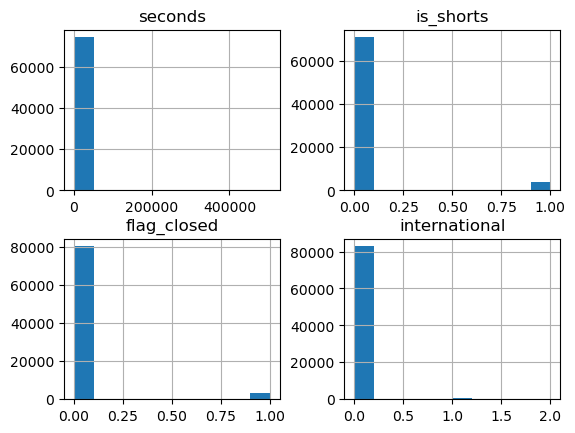

In [8]:
df_train = download_and_get_info(PATH_TRAIN)

Из полученных данных видим, что обучающий датафрейм содержит 83 411 строк и 16 столбцов, полных дубликатов нет. В ряде столбцов (seconds, is-shorts, broadcast, language) наблюдается достаточно большое количество пропусков. Столлбцы - broadcast,is_shorts, flag_closed, international - имеют только два значения 1 и 0, но в них есть пропуски. Для более детального ознакомления с данными посмотрим какие уникальные значения и в каком количестве встречаются в столбцах- 'cartoon',  'yt_channel_type', 'language'

In [9]:
columns_1 = ['cartoon', 'yt_channel_type', 'language']
for column in columns_1:
    print(df_train[column].value_counts()) #normalize=True
    print('-' * 60)

cartoon
none                          78231
Маша и медведь                  853
Говорящий Том                   589
Буба                            529
Кошечки собачки                 437
Енотки                          379
Бэтмен                          353
ЖилаБыла Царевна                229
Оранжевая корова                227
Зебра в клеточку                188
Фиксики                         151
Чик-Чирикино                    137
Сумка                           134
Черепашки Ниндзя                104
Чуддики                          86
My little pony                   81
Свинка Пеппа                     69
Синий трактор                    67
Чучело-Мяучело                   64
Малышарики                       60
Пороро                           51
Приключения Пети и Волка         41
Смешарики                        41
Трансформеры                     40
Простоквашино                    35
Царевны                          32
Щенячий патруль                  32
Cry babies magic tea

В целевой переменной cartoon наблюдается сильный дисбаланс классов, значение none превышает 90%, это надо учесть при разработке решения по калссификации. 
Столбец language - тут мы видим, что в данном столбце пропусков более 99 %, в остальном встречается три языка (английский, испанский и арабский), это также необходимо учесть при разработке решения

### Тестовый датасет

Проводим аналогичные исследования, с учетом того, что в тестовом датасете отсутсвует целевая переменная

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN,five little monsters halloween rhymes nursery ...,[five little monsters halloween rhymes nursery...,"['five', 'Kids Tv', 'Russia']"
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,https://www.youtube.com/channel/UCIDMp2rLX4G5C...,Блогеры,0.0,0.0,NaN,Tractor mini Bulldozer to making concrete road...,[Tractor mini Bulldozer to making concrete roa...,"['Bulldozer', 'Road Roller']"
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0.0,NaN,Who is the Last to STOP DRIVING Won the Challenge,[Who is the Last to STOP DRIVING Won the Chall...,[]
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,https://youtube.com/channel/UC_J_9-qRfVtKIkq7S...,Детские,0.0,0.0,NaN,Cartoons about cars and trains for children. E...,[Cartoons about cars and trains for children. ...,[]
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,https://youtube.com/channel/UCSmqZkD74x3TLt6eR...,Блогеры,0.0,0.0,NaN,TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 PL...,[TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 P...,[]


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             55608 non-null  object 
 1   reel_name        55605 non-null  object 
 2   yt_reel_id       55608 non-null  object 
 3   url              55608 non-null  object 
 4   text             55608 non-null  object 
 5   seconds          49807 non-null  float64
 6   is_shorts        49807 non-null  float64
 7   broadcast        49807 non-null  object 
 8   yt_channel_id    55584 non-null  object 
 9   yt_channel_name  55580 non-null  object 
 10  yt_ch_url        55580 non-null  object 
 11  yt_channel_type  55580 non-null  object 
 12  flag_closed      55580 non-null  float64
 13  international    55580 non-null  float64
 14  language         337 non-null    object 
 15  reel_name_eng    55608 non-null  object 
 1

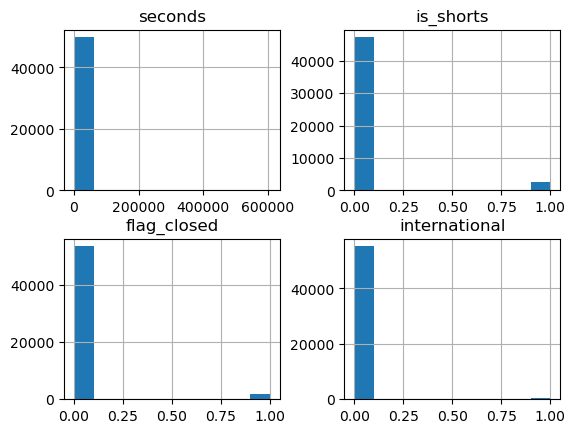

In [10]:
df_test = download_and_get_info(PATH_TEST)

In [11]:
columns_2 = ['yt_channel_type', 'language']
for column in columns_2:
    print(df_test[column].value_counts()) #normalize=True
    print('-' * 60)

yt_channel_type
Мультфильмы    27009
Блогеры        22084
Детские         6348
Shorts           139
Name: count, dtype: int64
------------------------------------------------------------
language
english    145
spanish    137
arabic      55
Name: count, dtype: int64
------------------------------------------------------------


Из полученных данных видим, что тестовый датафрейм содержит 55608  строк и 15 столбцов (отсутвует столбец с целевой переменной cartoon), полных дубликатов нет. В данных наблюдается схожая с обучающей выборкой картина. В столбцах seconds, is-shorts, broadcast, language достаточно большое количество пропусков. Столлбцы - broadcast,is_shorts, flag_closed, international - имеют только два значения 1 и 0, но в них есть пропуски. Также поммимо пропусков в столбце language есть три значения языка (английский, испанский и арабский), аналогично обучающей выборке. Уникальные значения в столбце yt_channel_type в обучающей и тестовой выборках также совпадают.

**Вывод:** Провели загрузку данных и первичное ознакомление с ними. Видим что структура данных обучающей и тестовой выборки совпадают, за исключением столбца cartoon, который является целевой переменной и отсутсвует в тестовой выборкен. В данных нет полных дубликатов, присутвуют пропуски, которые для отдельных признаков надо попробовать обработать. В целевой переменной наблюдается сильный дисбаланс классов и предварительно в данных присутсвуют тексты на 3 языках (английский, испанский, арабский), это необходимо учесть при разработке решения для классификации.

### Посмотрим sample_submission.csv 

In [12]:
submission_sampl = pd.read_csv('submission.csv')
submission_sampl.head()

,yt_reel_id,prediction
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none


## Проведем исследовательский анализ данных и по необходимости обработаем пропуски

### Обучающая выборка

#### Посмотрим данные, в котрых отсутсвуют название ролика

In [13]:
df_train.query('reel_name.isna()')

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent
15331,2024-09-07,NaN,_S1ro6h6Ils,none,https://www.youtube.com/watch?v=_S1ro6h6Ils,[],19.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN,in,[],[]
17756,2023-01-09,NaN,daJ0drzcYz4,none,https://www.youtube.com/watch?v=daJ0drzcYz4,[] shorts shortsviral babyalive deixaolike],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN,in,[] shorts shortsviral babyalive deixaolike],[]
66766,2022-11-08,NaN,Zu_vwE48tqI,none,https://www.youtube.com/watch?v=Zu_vwE48tqI,[] shortsviral babyalive babyalive brincadeira],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN,in,[] shortsviral babyalive babyalive brazilla],[]


#### Посмотри зависимость между id канала и целевой переменной

In [14]:
df_train.pivot_table(index=['yt_channel_id', 'yt_channel_name','cartoon'], values='yt_reel_id', aggfunc='count')


yt_reel_id
yt_channel_id            yt_channel_name                 cartoon                   
UC-Bc-4nV2-Tk4Af2rqrmrjA HomeAnimations Мультики про тан none                   748
UC-C8a01ToQqaNCozQbNa9pg Мультфильмы Серия Kids Cartoons none                   230
                                                         Свинка Пеппа             4
UC-jHNWViReG6R_kJ6b45FdQ Family Box                      My little pony           1
                                                         none                   778
...                                                                             ...
UCxWkNmkeAL52VTJyBlIJRXw Теремок ТВ                      Сумка                    3
                                                         Трансформеры            20
                                                         Царевны                  3
UCy1D4WGprdBxv0FaC6IH-wg Лум Планет                      none                   624
UCzHZHO-Z_fR56iOpGWNgzfQ Короткая анимация               none                   559

[399 rows x 1 columns]

In [15]:
df_train['international'].unique()

array([0., 1., 2.])

In [16]:
df_train['international'] = df_train['international'].astype('int')

In [17]:
df_train['international'] = df_train['international'].astype('category')

In [18]:
df_train['international'].unique()

[0, 1, 2]
Categories (3, int32): [0, 1, 2]

In [19]:
df_train['yt_channel_id'] = df_train['yt_channel_id'].astype('category')

In [20]:
df_train.query('international == 1')['cartoon'].value_counts()

C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\643130039.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_train.query('international == 1')['cartoon'].value_counts()


cartoon
Енотки              327
Оранжевая корова    170
Name: count, dtype: int64

In [21]:
df_train.query('yt_channel_name == "Котёнок Котэ Песенки и мультики"')['cartoon'].unique()

array(['none', 'Акуленок'], dtype=object)

### Сделаем baseline решение  - будем решать поставленную задачу в следующей последовательности - лемматизация - создание мешка слов или оценка важности слова (TF_IDF) - обучение модели.¶
Первоначальные настройки: учитываем дисбаланс классов (class_weight='balanced'). Отслеживаем метрику f1, среднне - 'macro'. В качестве признаков используем id канала, 

#### Проведем очистку текста (оставим только буквы алфавита) и лемматизаци названия мультфильмов. Для этого сначала напишем функцию очистки и лемматизации текста, потом применим ее ко всему датасету.

In [22]:
lemmatizer = WordNetLemmatizer()

In [23]:
def lemmatize_clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatizer.lemmatize(w, pos = 'v') for w in text] # лемматирзируем слова
    return ' '.join(text) # соединяем слова

df_train['lemm_name'] = df_train['reel_name_eng'].apply(lemmatize_clean_text)

df_train.head()

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent,lemm_name
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0,NaN,100 gifts and only one you can keep for yourself,[100 gifts and only one you can keep],"['100', 'only one']",gift and only one you can keep for yourself
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0,NaN,BUGGED Lisa in Real Life ARTHUR and NASTYA Fol...,[LIZA BUGGED in Real Life ARTHUR and NASTYA Fo...,[],bug lisa in real life arthur and nastya follow me
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0,NaN,The Terrible Family Best SISTERLY moments with...,[Terrible Family Best SISTER moments with Chlo...,"['SISTERLY', 'Chloe', 'Phoebe', 'Nora', 'The T...",the terrible family best sisterly moments with...
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0,NaN,How to make a fabric necklace with your own hands,[How to make a fabric necklace with your own h...,[],how to make a fabric necklace with your own hand
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0,NaN,Sleepover Rules Om Nom Stories Cartoon for k...,[Sleepover Rules Om Nom Stories Cartoon for ...,['Kedoo Toons TV'],sleepover rule om nom stories cartoon for kid ...


In [24]:
df_train.columns

Index(['date', 'reel_name', 'yt_reel_id', 'cartoon', 'url', 'text', 'seconds',
       'is_shorts', 'broadcast', 'yt_channel_id', 'yt_channel_name',
       'yt_ch_url', 'yt_channel_type', 'flag_closed', 'international',
       'language', 'reel_name_eng', 'text_eng', 'name_ent', 'lemm_name'],
      dtype='object')

In [25]:
train_features = df_train[['yt_channel_id', 'international', 'lemm_name']]

In [26]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   yt_channel_id  83411 non-null  category
 1   international  83411 non-null  category
 2   lemm_name      83411 non-null  object  
dtypes: category(2), object(1)
memory usage: 906.0+ KB


In [27]:
train_features['lemm_name']

0              gift and only one you can keep for yourself
1        bug lisa in real life arthur and nastya follow me
2        the terrible family best sisterly moments with...
3         how to make a fabric necklace with your own hand
4        sleepover rule om nom stories cartoon for kid ...
                               ...                        
83406    tonight on ivi a href https www ivi ru watch k...
83407                               as easy as shell pears
83408    dobrynya nikitich and zmey gorynych film about...
83409    senya and papa run away from the dinosaurs fun...
83410    live stream masha and the bear masha say that ...
Name: lemm_name, Length: 83411, dtype: object

### Модель решающее дерево

In [28]:
cat_columns = train_features.select_dtypes(include='category').columns
text_columns = train_features.select_dtypes(include='object').columns
print(cat_columns)
text_columns

Index(['yt_channel_id', 'international'], dtype='object')


Index(['lemm_name'], dtype='object')

In [29]:
train_target = df_train['cartoon']

In [30]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32)

In [32]:
column_transformer_rf = make_column_transformer((OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1,  dtype=np.float32), cat_columns),
                                                (TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), 2),
                                                                                          remainder = 'passthrough')


In [33]:
train_features_rf = column_transformer_rf.fit_transform(train_features)

In [34]:
train_features_rf 

<83411x18480 sparse matrix of type '<class 'numpy.float32'>'
	with 642261 stored elements in Compressed Sparse Row format>

In [35]:
train_c = pd.DataFrame(train_target)

In [36]:
train_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cartoon  83411 non-null  object
dtypes: object(1)
memory usage: 651.8+ KB


In [37]:
encoder = OrdinalEncoder()

In [38]:
train_c['cartoon_encod'] = encoder.fit_transform(train_c[['cartoon']])

In [39]:
train_c['cartoon_encod'] = train_c['cartoon_encod'].astype('int')

In [40]:
train_c.head()

,cartoon,cartoon_encod
0,none,3
1,none,3
2,none,3
3,none,3
4,none,3


In [41]:
train_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cartoon        83411 non-null  object
 1   cartoon_encod  83411 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 977.6+ KB


In [42]:
target_encoder = train_c.pivot_table(index=['cartoon', 'cartoon_encod']).reset_index()
target_encoder

,cartoon,cartoon_encod
0,Cry babies magic tears,0
1,Enchantimals (Эншантималс),1
2,My little pony,2
3,none,3
4,Акуленок,4
5,Барбоскины,5
6,Бременские музыканты,6
7,Буба,7
8,Бэтмен,8
9,Вспыш,9


In [43]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [44]:
score = cross_val_score(estimator=model_dt,
                            X=train_features_rf,
                            y=train_c['cartoon_encod'],
                            scoring=make_scorer(f1_score, average='macro'),
                            cv=2)

In [45]:
score

array([0.74469805, 0.6917298 ])

#### Подбор гимперпараметров для модели решающее дерево

In [46]:
pipline_dt = make_pipeline(column_transformer_rf, model_dt)
pipline_dt 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'numpy.float32'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['yt_channel_id', 'international'], dtype='object')),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                                                  stop_words=['through',
                                                                              'into',
                                                                              'me',
                                                                              'to',
                                                                              'from',
                                                                              'doesn',
                                                                              'out',
                                                                              'each',
                                                                              'that',
                                                                              'as',
                                                                              'wouldn',
                                                                              "hasn't",
                                                                              "didn't",
                                                                              'they',
                                                                              'we',
                                                                              'and',
                                                                              'myself',
                                                                              'mustn',
                                                                              "weren't",
                                                                              'most',
                                                                              'in',
                                                                              'did',
                                                                              'these',
                                                                              'again',
                                                                              "haven't",
                                                                              'same',
                                                                              'other',
                                                                              'only',
                                                                              'weren',
                                                                              "needn't", ...]),
                                                  2)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=12345))])

In [47]:
              
param_dt = {
    'decisiontreeclassifier__max_depth': range(1, 150),
    'decisiontreeclassifier__min_samples_split': (2, 3, 4),
    'decisiontreeclassifier__min_samples_leaf': (1, 2, 3, 4),
   
}



grid_dt = RandomizedSearchCV(pipline_dt, param_dt, cv=2, n_iter=150, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_dt.fit(train_features, train_c['cartoon_encod'])


dt_best_f1 = grid_dt.best_score_
dt_best_model = grid_dt.best_estimator_
dt_best_params = grid_dt.best_params_
           

print(f'F1 лучшей модели DecisionTreeClassifier на обучающей выборке: {dt_best_f1}')
print(f'Гиперпараметры лучшей модели: {dt_best_params}')

F1 лучшей модели DecisionTreeClassifier на обучающей выборке: 0.7206844463798723
Гиперпараметры лучшей модели: {'decisiontreeclassifier__min_samples_split': 3, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_depth': 126}


### Модель Логистической регрессии

In [168]:
model_lr_1 = LogisticRegression(class_weight = 'balanced', random_state=RANDOM_STATE)

In [169]:
column_transformer_lr_1 = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore', dtype=np.float32), cat_columns),
                                                (TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), 2),
                                                 remainder = 'passthrough')

In [170]:
pipline_lr_1 = make_pipeline(column_transformer_lr_1, model_lr_1)

In [171]:
param_lr_1 = {
    'logisticregression__solver': ['lbfgs', 'newton-cg'],
    'logisticregression__C': range(5, 16),
       
}



grid_lr_1 = RandomizedSearchCV(pipline_lr_1, param_lr_1, cv=2, n_iter=30, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_lr_1.fit(train_features, train_c['cartoon_encod'])


lr_best_score_1 = grid_lr_1.best_score_
lr_best_model_2 = grid_lr_1.best_estimator_
lr_best_params_2 = grid_lr_1.best_params_
           

print(f'F1 лучшей модели LR на обучающей выборке: {lr_best_score_1}')
print(f'Гиперпараметры лучшей модели: {lr_best_params_2}')

C:\Users\bniko\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 22 is smaller than n_iter=30. Running 22 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


F1 лучшей модели LR на обучающей выборке: 0.6880581171735967
Гиперпараметры лучшей модели: {'logisticregression__solver': 'newton-cg', 'logisticregression__C': 15}


### Модель случайный лес

In [48]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [49]:
score_rf = cross_val_score(estimator=model_rf,
                            X=train_features_rf,
                            y=train_c['cartoon_encod'],
                            scoring=make_scorer(f1_score, average='macro'),
                            cv=2)

In [50]:
score_rf

array([0.52685636, 0.4928171 ])

In [173]:
pipline_rf = make_pipeline(column_transformer_rf, model_rf)
                
param_rf = {
    'randomforestclassifier__n_estimators': range(10, 80, 10),
    'randomforestclassifier__max_depth': range(1, 10),
    
}



grid_rf = RandomizedSearchCV(pipline_rf, param_rf, cv=2, n_iter=50, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_rf.fit(train_features, train_c['cartoon_encod'])


rf_best_f1 = grid_rf.best_score_
rf_best_model = grid_rf.best_estimator_
rf_best_params = grid_rf.best_params_
           

print(f'f1 лучшей модели RandomForestRegressor на обучающей выборке: {rf_best_f1}')
print(f'Гиперпараметры лучшей модели: {rf_best_params}')

f1 лучшей модели RandomForestRegressor на обучающей выборке: 0.259907239749116
Гиперпараметры лучшей модели: {'randomforestclassifier__n_estimators': 10, 'randomforestclassifier__max_depth': 9}


### Получение предсказаний на тестовой выборке для модели решающее дерево

In [52]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             55608 non-null  object 
 1   reel_name        55605 non-null  object 
 2   yt_reel_id       55608 non-null  object 
 3   url              55608 non-null  object 
 4   text             55608 non-null  object 
 5   seconds          49807 non-null  float64
 6   is_shorts        49807 non-null  float64
 7   broadcast        49807 non-null  object 
 8   yt_channel_id    55584 non-null  object 
 9   yt_channel_name  55580 non-null  object 
 10  yt_ch_url        55580 non-null  object 
 11  yt_channel_type  55580 non-null  object 
 12  flag_closed      55580 non-null  float64
 13  international    55580 non-null  float64
 14  language         337 non-null    object 
 15  reel_name_eng    55608 non-null  object 
 16  text_eng         55608 non-null  object 
 17  name_ent    

In [53]:
df_test['lemm_name'] = df_test['reel_name_eng'].apply(lemmatize_clean_text)


In [54]:
df_test['yt_channel_id'] = df_test['yt_channel_id'].fillna('unknown')


In [55]:
df_test['yt_channel_id'] = df_test['yt_channel_id'].astype('category')

In [56]:
df_test['international'] = df_test['international'].fillna(2)

In [57]:
df_test['international'] = df_test['international'].astype('int')

In [58]:
df_test['international'] = df_test['international'].astype('category')

In [59]:
df_test['international'].value_counts()

international
0    55243
1      337
2       28
Name: count, dtype: int64

In [60]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   date             55608 non-null  object  
 1   reel_name        55605 non-null  object  
 2   yt_reel_id       55608 non-null  object  
 3   url              55608 non-null  object  
 4   text             55608 non-null  object  
 5   seconds          49807 non-null  float64 
 6   is_shorts        49807 non-null  float64 
 7   broadcast        49807 non-null  object  
 8   yt_channel_id    55608 non-null  category
 9   yt_channel_name  55580 non-null  object  
 10  yt_ch_url        55580 non-null  object  
 11  yt_channel_type  55580 non-null  object  
 12  flag_closed      55580 non-null  float64 
 13  international    55608 non-null  category
 14  language         337 non-null    object  
 15  reel_name_eng    55608 non-null  object  
 16  text_eng         55608 non-null  object 

In [61]:
test_features = df_test[['yt_channel_id', 'international', 'lemm_name']]

In [62]:
prediction_dt = dt_best_model.predict(test_features)

In [63]:
prediction_dt

array([ 3,  3,  3, ..., 32,  3,  3])

In [64]:
predictions_test_dt = pd.Series(prediction_dt)

In [65]:
df_test['prediction'] = predictions_test_dt
df_test.head()

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent,lemm_name,prediction
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0,NaN,five little monsters halloween rhymes nursery ...,[five little monsters halloween rhymes nursery...,"['five', 'Kids Tv', 'Russia']",five little monsters halloween rhyme nursery r...,3
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,https://www.youtube.com/channel/UCIDMp2rLX4G5C...,Блогеры,0.0,0,NaN,Tractor mini Bulldozer to making concrete road...,[Tractor mini Bulldozer to making concrete roa...,"['Bulldozer', 'Road Roller']",tractor mini bulldozer to make concrete road c...,3
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0,NaN,Who is the Last to STOP DRIVING Won the Challenge,[Who is the Last to STOP DRIVING Won the Chall...,[],who be the last to stop drive win the challenge,3
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,https://youtube.com/channel/UC_J_9-qRfVtKIkq7S...,Детские,0.0,0,NaN,Cartoons about cars and trains for children. E...,[Cartoons about cars and trains for children. ...,[],cartoon about cars and train for children educ...,3
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,https://youtube.com/channel/UCSmqZkD74x3TLt6eR...,Блогеры,0.0,0,NaN,TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 PL...,[TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 P...,[],too small portal to end in minecraft only play...,3


In [66]:
sub = df_test[['yt_reel_id','prediction']]
sub.head()

,yt_reel_id,prediction
0,RBw4j0aMWyM,3
1,5wTfpmlZe5k,3
2,Fd9YA-oDjSo,3
3,NXCHY_J-5v0,3
4,XM-GRekoYzs,3


In [67]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   yt_reel_id  55608 non-null  object
 1   prediction  55608 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 651.8+ KB


In [68]:
sub.rename(columns={"prediction": "cartoon_encod"}, inplace=True )


C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\4124640158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.rename(columns={"prediction": "cartoon_encod"}, inplace=True )


In [69]:
sub.head()

,yt_reel_id,cartoon_encod
0,RBw4j0aMWyM,3
1,5wTfpmlZe5k,3
2,Fd9YA-oDjSo,3
3,NXCHY_J-5v0,3
4,XM-GRekoYzs,3


In [70]:
sub_1 = sub.merge(target_encoder, on='cartoon_encod', how='left')

In [71]:
sub_1 = sub_1.drop('cartoon_encod', axis=1)

In [72]:
sub_1.rename(columns={"cartoon": "prediction"}, inplace=True)

In [73]:
sub_1

,yt_reel_id,prediction
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none
...,...,...
55603,z8QQtWqr7lY,none
55604,VMBC_ahkjjU,none
55605,zwSu3nUWQKM,Смешарики
55606,yieUVOAHZiA,none


In [74]:
#sub_1.to_csv('submission_dt_2.csv', index=False)

## Добавим признаки, выделим следующие признаки из названия роликов, слова с большой буквы, слова написанные заглавными буквами, длину названия

функция дл я получения длины слов, списка солов написанныз заглавными буквами

In [87]:
def get_len_text(row):
    return len(str(row))

In [92]:
def get_capitalized_words(row):
    capitalized_words = [word for word in str(row).split() if word.isupper()]
    return ' '.join(capitalized_words)

In [93]:
df_train['name_cap'] = df_train['reel_name'].apply(get_capitalized_words)

In [94]:
# df_train.head()

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,...,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent,lemm_name,name_cap,name_len
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,...,Блогеры,0.0,0,NaN,100 gifts and only one you can keep for yourself,[100 gifts and only one you can keep],"['100', 'only one']",gift and only one you can keep for yourself,,46
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,...,Блогеры,0.0,0,NaN,BUGGED Lisa in Real Life ARTHUR and NASTYA Fol...,[LIZA BUGGED in Real Life ARTHUR and NASTYA Fo...,[],bug lisa in real life arthur and nastya follow me,ЗАБАГАЛИ АРТУР НАСТЯ,54
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,...,Мультфильмы,0.0,0,NaN,The Terrible Family Best SISTERLY moments with...,[Terrible Family Best SISTER moments with Chlo...,"['SISTERLY', 'Chloe', 'Phoebe', 'Nora', 'The T...",the terrible family best sisterly moments with...,СЕСТРИНСКИЕ,85
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,...,Блогеры,0.0,0,NaN,How to make a fabric necklace with your own hands,[How to make a fabric necklace with your own h...,[],how to make a fabric necklace with your own hand,,43
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,...,Мультфильмы,0.0,0,NaN,Sleepover Rules Om Nom Stories Cartoon for k...,[Sleepover Rules Om Nom Stories Cartoon for ...,['Kedoo Toons TV'],sleepover rule om nom stories cartoon for kid ...,TV,64


In [95]:
df_train['name_len'] = df_train['reel_name'].apply(get_len_text)

In [96]:
df_train.head()

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,...,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent,lemm_name,name_cap,name_len
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,...,Блогеры,0.0,0,NaN,100 gifts and only one you can keep for yourself,[100 gifts and only one you can keep],"['100', 'only one']",gift and only one you can keep for yourself,,46
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,...,Блогеры,0.0,0,NaN,BUGGED Lisa in Real Life ARTHUR and NASTYA Fol...,[LIZA BUGGED in Real Life ARTHUR and NASTYA Fo...,[],bug lisa in real life arthur and nastya follow me,ЗАБАГАЛИ АРТУР НАСТЯ,54
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,...,Мультфильмы,0.0,0,NaN,The Terrible Family Best SISTERLY moments with...,[Terrible Family Best SISTER moments with Chlo...,"['SISTERLY', 'Chloe', 'Phoebe', 'Nora', 'The T...",the terrible family best sisterly moments with...,СЕСТРИНСКИЕ,85
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,...,Блогеры,0.0,0,NaN,How to make a fabric necklace with your own hands,[How to make a fabric necklace with your own h...,[],how to make a fabric necklace with your own hand,,43
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,...,Мультфильмы,0.0,0,NaN,Sleepover Rules Om Nom Stories Cartoon for k...,[Sleepover Rules Om Nom Stories Cartoon for ...,['Kedoo Toons TV'],sleepover rule om nom stories cartoon for kid ...,TV,64


In [111]:
def get_str(row):
    lst = row.to_list
    return ' '.join(str(el) for el in lst)

In [118]:
df_train = df_train.drop('name_ent_str', axis=1 )

In [119]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   date             83411 non-null  object  
 1   reel_name        83408 non-null  object  
 2   yt_reel_id       83411 non-null  object  
 3   cartoon          83411 non-null  object  
 4   url              83411 non-null  object  
 5   text             83411 non-null  object  
 6   seconds          74653 non-null  float64 
 7   is_shorts        74653 non-null  float64 
 8   broadcast        74653 non-null  object  
 9   yt_channel_id    83411 non-null  category
 10  yt_channel_name  83363 non-null  object  
 11  yt_ch_url        83363 non-null  object  
 12  yt_channel_type  83363 non-null  object  
 13  flag_closed      83363 non-null  float64 
 14  international    83411 non-null  category
 15  language         497 non-null    object  
 16  reel_name_eng    83411 non-null  object 

### Аналогично поступаем с тестовой выборкой

In [120]:
df_test['name_cap'] = df_test['reel_name'].apply(get_capitalized_words)

In [121]:
df_test['name_len'] = df_test['reel_name'].apply(get_len_text)

In [122]:
df_test.head(3)

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,...,flag_closed,international,language,reel_name_eng,text_eng,name_ent,lemm_name,prediction,name_cap,name_len
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,...,0.0,0,NaN,five little monsters halloween rhymes nursery ...,[five little monsters halloween rhymes nursery...,"['five', 'Kids Tv', 'Russia']",five little monsters halloween rhyme nursery r...,3,,80
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,...,0.0,0,NaN,Tractor mini Bulldozer to making concrete road...,[Tractor mini Bulldozer to making concrete roa...,"['Bulldozer', 'Road Roller']",tractor mini bulldozer to make concrete road c...,3,,82
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,...,0.0,0,NaN,Who is the Last to STOP DRIVING Won the Challenge,[Who is the Last to STOP DRIVING Won the Chall...,[],who be the last to stop drive win the challenge,3,ПЕРЕСТАНЕТ,48


In [124]:
 df_test['name_ent_len'] = df_test['name_ent'].apply(get_len_text)

In [127]:
df_train['name_ent_len'] = df_train['name_ent'].apply(get_len_text)

In [129]:
df_train['text_lemm'] = df_train['text'].apply(lemmatize_clean_text)

In [131]:
df_test['text_lemm'] = df_test['text'].apply(lemmatize_clean_text)

In [133]:
df_train_merg = df_train.merge(target_encoder, on='cartoon', how='left')

In [135]:
df_train_merg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   date             83411 non-null  object  
 1   reel_name        83408 non-null  object  
 2   yt_reel_id       83411 non-null  object  
 3   cartoon          83411 non-null  object  
 4   url              83411 non-null  object  
 5   text             83411 non-null  object  
 6   seconds          74653 non-null  float64 
 7   is_shorts        74653 non-null  float64 
 8   broadcast        74653 non-null  object  
 9   yt_channel_id    83411 non-null  category
 10  yt_channel_name  83363 non-null  object  
 11  yt_ch_url        83363 non-null  object  
 12  yt_channel_type  83363 non-null  object  
 13  flag_closed      83363 non-null  float64 
 14  international    83411 non-null  category
 15  language         497 non-null    object  
 16  reel_name_eng    83411 non-null  object 

In [136]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   date             55608 non-null  object  
 1   reel_name        55605 non-null  object  
 2   yt_reel_id       55608 non-null  object  
 3   url              55608 non-null  object  
 4   text             55608 non-null  object  
 5   seconds          49807 non-null  float64 
 6   is_shorts        49807 non-null  float64 
 7   broadcast        49807 non-null  object  
 8   yt_channel_id    55608 non-null  category
 9   yt_channel_name  55580 non-null  object  
 10  yt_ch_url        55580 non-null  object  
 11  yt_channel_type  55580 non-null  object  
 12  flag_closed      55580 non-null  float64 
 13  international    55608 non-null  category
 14  language         337 non-null    object  
 15  reel_name_eng    55608 non-null  object  
 16  text_eng         55608 non-null  object 

## Теперь обучим модель на большем наборе признаков

In [137]:
df_train_merg.columns

Index(['date', 'reel_name', 'yt_reel_id', 'cartoon', 'url', 'text', 'seconds',
       'is_shorts', 'broadcast', 'yt_channel_id', 'yt_channel_name',
       'yt_ch_url', 'yt_channel_type', 'flag_closed', 'international',
       'language', 'reel_name_eng', 'text_eng', 'name_ent', 'lemm_name',
       'name_cap', 'name_len', 'name_ent_len', 'text_lemm', 'cartoon_encod'],
      dtype='object')

In [138]:
train_featuires_1 = df_train_merg[['yt_channel_id', 'international', 'name_ent', 'lemm_name', 'name_cap', 'name_len']]

In [147]:
train_featuires_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   yt_channel_id  83411 non-null  category
 1   international  83411 non-null  category
 2   name_ent       83411 non-null  object  
 3   lemm_name      83411 non-null  object  
 4   name_cap       83411 non-null  object  
 5   name_len       83411 non-null  int32   
dtypes: category(2), int32(1), object(3)
memory usage: 2.5+ MB


In [146]:
train_featuires_1['name_len'] = train_featuires_1['name_len'].astype('int32')

C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\2303168441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_featuires_1['name_len'] = train_featuires_1['name_len'].astype('int32')


### Создаем колум трансформер для данного набора признаков

In [142]:
cat_columns_1 = train_featuires_1.select_dtypes(include='category').columns
cat_columns_1

Index(['yt_channel_id', 'international'], dtype='object')

In [158]:
num_columns = train_featuires_1.select_dtypes(include='number').columns

In [159]:
num_columns

Index(['name_len'], dtype='object')

In [148]:
column_transformer_rf_1 = make_column_transformer((OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1,  dtype=np.float32), cat_columns_1),
                                                (TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), 3),
                                                  (CountVectorizer(dtype=np.float32), 2),
                                                  (CountVectorizer(dtype=np.float32), 4),
                                                                                          remainder = 'passthrough')


In [149]:
train_features_rf_1 = column_transformer_rf_1.fit_transform(train_featuires_1)

In [150]:
train_features_rf_1

<83411x46749 sparse matrix of type '<class 'numpy.float64'>'
	with 1023349 stored elements in Compressed Sparse Row format>

In [151]:
model_dt_1 = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [152]:
score_1 = cross_val_score(estimator=model_dt,
                            X=train_features_rf_1,
                            y=train_c['cartoon_encod'],
                            scoring=make_scorer(f1_score, average='macro'),
                            cv=2)

In [153]:
score_1

array([0.72520566, 0.70060814])

In [154]:
pipline_dt_1 = make_pipeline(column_transformer_rf_1, model_dt_1)
pipline_dt 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'numpy.float32'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['yt_channel_id', 'international'], dtype='object')),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                                                  stop_words=['through',
                                                                              'into',
                                                                              'me',
                                                                              'to',
                                                                              'from',
                                                                              'doesn',
                                                                              'out',
                                                                              'each',
                                                                              'that',
                                                                              'as',
                                                                              'wouldn',
                                                                              "hasn't",
                                                                              "didn't",
                                                                              'they',
                                                                              'we',
                                                                              'and',
                                                                              'myself',
                                                                              'mustn',
                                                                              "weren't",
                                                                              'most',
                                                                              'in',
                                                                              'did',
                                                                              'these',
                                                                              'again',
                                                                              "haven't",
                                                                              'same',
                                                                              'other',
                                                                              'only',
                                                                              'weren',
                                                                              "needn't", ...]),
                                                  2)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=12345))])

In [156]:
param_dt_1 = {
    'decisiontreeclassifier__max_depth': range(1, 150),
    'decisiontreeclassifier__min_samples_split': (2, 3, 4),
    'decisiontreeclassifier__min_samples_leaf': (1, 2, 3, 4, 5),
   
}



grid_dt_1 = RandomizedSearchCV(pipline_dt_1, param_dt_1, cv=2, n_iter=160, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_dt_1.fit(train_featuires_1, train_c['cartoon_encod'])


dt_best_f1_1 = grid_dt_1.best_score_
dt_best_model_1 = grid_dt_1.best_estimator_
dt_best_params_1 = grid_dt_1.best_params_
           

print(f'F1 лучшей модели DecisionTreeClassifier на обучающей выборке: {dt_best_f1_1}')
print(f'Гиперпараметры лучшей модели: {dt_best_params_1}')

F1 лучшей модели DecisionTreeClassifier на обучающей выборке: 0.7137828692262524
Гиперпараметры лучшей модели: {'decisiontreeclassifier__min_samples_split': 3, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_depth': 101}


## Логистическая регрессия

In [157]:
model_lr = LogisticRegression(class_weight = 'balanced', random_state=RANDOM_STATE)

In [161]:
column_transformer_lr = make_column_transformer((StandardScaler(),num_columns), 
                                                (OneHotEncoder(drop='first', handle_unknown='ignore', dtype=np.float32), cat_columns_1),
                                                (TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), 3),
                                                  (CountVectorizer(dtype=np.float32), 2),
                                                  (CountVectorizer(dtype=np.float32), 4),
                                                                                          remainder = 'passthrough')

In [163]:
pipline_lr = make_pipeline(column_transformer_lr, model_lr)
pipline_lr 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['name_len'], dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.float32'>,
                                                                handle_unknown='ignore'),
                                                  Index(['yt_channel_id', 'international'], dtype='object')),
                                                 ('tfidfvectorizer',
                                                  TfidfVectori...
                                                                              'myself',
                                                                              'mustn',
                                                                              "weren't",
                                                                              'most',
                                                                              'in',
                                                                              'did',
                                                                              'these',
                                                                              'again',
                                                                              "haven't",
                                                                              'same',
                                                                              'other',
                                                                              'only',
                                                                              'weren',
                                                                              "needn't", ...]),
                                                  3),
                                                 ('countvectorizer-1',
                                                  CountVectorizer(dtype=<class 'numpy.float32'>),
                                                  2),
                                                 ('countvectorizer-2',
                                                  CountVectorizer(dtype=<class 'numpy.float32'>),
                                                  4)])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced',
                                    random_state=12345))])

In [167]:
param_lr = {
    'logisticregression__solver': ['lbfgs', 'newton-cg'],
    'logisticregression__C': range(5, 16),
       
}



grid_lr = RandomizedSearchCV(pipline_lr, param_lr, cv=2, n_iter=30, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_lr.fit(train_featuires_1, train_c['cartoon_encod'])


lr_best_score = grid_lr.best_score_
lr_best_model_1 = grid_lr.best_estimator_
lr_best_params_1 = grid_lr.best_params_
           

print(f'F1 лучшей модели LR на обучающей выборке: {lr_best_score}')
print(f'Гиперпараметры лучшей модели: {lr_best_params_1}')

C:\Users\bniko\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 22 is smaller than n_iter=30. Running 22 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


F1 лучшей модели LR на обучающей выборке: 0.7027423282758635
Гиперпараметры лучшей модели: {'logisticregression__solver': 'newton-cg', 'logisticregression__C': 15}


## Исследуем вариант с леммитизацией текста и id канала

In [191]:
train_featuires_2 = df_train_merg[['yt_channel_id', 'text_lemm']]

In [192]:
test_features_2 = df_test[['yt_channel_id', 'text_lemm']]

In [193]:
test_features_2.shape

(55608, 2)

In [194]:
cat_columns_2 = train_featuires_2.select_dtypes(include='category').columns

In [195]:
column_transformer_rf_2 = make_column_transformer((OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1,  dtype=np.float32), cat_columns_2),
                                                (TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), 1),
                                                    remainder = 'passthrough')

In [196]:
pipline_dt_2 = make_pipeline(column_transformer_rf_2, model_dt_1)

In [197]:
param_dt_1 = {
    'decisiontreeclassifier__max_depth': range(1, 150),
    'decisiontreeclassifier__min_samples_split': (2, 3, 4),
    'decisiontreeclassifier__min_samples_leaf': (1, 2, 3, 4, 5),
   
}



grid_dt_2 = RandomizedSearchCV(pipline_dt_2, param_dt_1, cv=2, n_iter=160, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_dt_2.fit(train_featuires_2, train_c['cartoon_encod'])


dt_best_f1_2 = grid_dt_2.best_score_
dt_best_model_2 = grid_dt_2.best_estimator_
dt_best_params_2 = grid_dt_2.best_params_
           

print(f'F1 лучшей модели DecisionTreeClassifier на обучающей выборке: {dt_best_f1_2}')
print(f'Гиперпараметры лучшей модели: {dt_best_params_2}')

F1 лучшей модели DecisionTreeClassifier на обучающей выборке: 0.4835185015318554
Гиперпараметры лучшей модели: {'decisiontreeclassifier__min_samples_split': 4, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_depth': 69}


In [181]:
prediction_dt_2 = dt_best_model_2.predict(test_features_2)

In [184]:
test_id = pd.DataFrame(df_test['yt_reel_id'])
test_id.head(2)

,yt_reel_id
0,RBw4j0aMWyM
1,5wTfpmlZe5k


In [185]:
test_id['cartoon_encod'] = prediction_dt_2 
test_id.head(2)

,yt_reel_id,cartoon_encod
0,RBw4j0aMWyM,3
1,5wTfpmlZe5k,3


In [186]:
sub_dt = test_id.merge(target_encoder, on='cartoon_encod', how='left')
sub_dt.head(2)

,yt_reel_id,cartoon_encod,cartoon
0,RBw4j0aMWyM,3,none
1,5wTfpmlZe5k,3,none


In [187]:
sub_dt = sub_dt.drop('cartoon_encod', axis=1)

In [188]:
sub_dt.rename(columns={"cartoon": "prediction"}, inplace=True)

In [189]:
sub_dt.head()

,yt_reel_id,prediction
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none


In [190]:
#sub_dt.to_csv('submission_dt_3.csv', index=False)

## теперь попробуем разбить данные на следующие группы:

- интернациональные каналы
- ролики, из которых удалось выделить именнованные сущности
- все остальные ролики

### Ролики с интернациональных каналов

In [202]:
df_train_inter = df_train_merg.query('international == 1')
df_train_inter.head()

C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\472817198.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_train_inter = df_train_merg.query('international == 1')


,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,...,language,reel_name_eng,text_eng,name_ent,lemm_name,name_cap,name_len,name_ent_len,text_lemm,cartoon_encod
154,2024-05-25,ألحان الراكون رسوم متحركة جديدة للأطفال,qKwG84uH4U0,Енотки,https://www.youtube.com/watch?v=qKwG84uH4U0,[ألحان الراكون رسوم متحركة جديدة للأطفال] ا...,1814.0,0.0,none,UCHIRpb4QywIbwW_wfXjxvXQ,...,arabic,Raccoon melodies new cartoon for children,"[Raccoon Melodies, a new animation for childre...",[],raccoon melodies new cartoon for children,,42,2,https www youtube com rockoonsarab videos,12
374,2024-04-02,ألحان الراكون رسوم متحركة جديدة للأطفال,kUvPN2OpgLU,Енотки,https://www.youtube.com/watch?v=kUvPN2OpgLU,[ألحان الراكون رسوم متحركة جديدة للأطفال] ا...,3623.0,0.0,none,UCHIRpb4QywIbwW_wfXjxvXQ,...,arabic,Raccoon melodies new cartoon for children,"[Raccoon Melodies, a new animation for childre...",[],raccoon melodies new cartoon for children,,42,2,https www youtube com rockoonsarab videos,12
402,2024-03-22,ألحان الراكون رسوم متحركة جديدة للأطفال,MfUp88lnRHI,Енотки,https://www.youtube.com/watch?v=MfUp88lnRHI,[ألحان الراكون رسوم متحركة جديدة للأطفال] ااش...,3618.0,0.0,none,UCHIRpb4QywIbwW_wfXjxvXQ,...,arabic,Raccoon melodies new cartoon for children,"[Raccoon Melodies, a new animation for childre...",[],raccoon melodies new cartoon for children,,40,2,https www youtube com rockoonsarab videos,12
454,2024-02-10,MUSIPACHES Dibujos animados para niños,I3zy5DtmJPE,Енотки,https://www.youtube.com/watch?v=I3zy5DtmJPE,[MUSIPACHES Dibujos animados para niños] Sus...,2897.0,0.0,none,UCWQjC5G2bSBarItYFvDL8VA,...,spanish,MUSIPACHES Cartoons for children,[MUSIPACHES Cartoons for children] Subscribe t...,['MUSIPACHES Cartoons for children'],musipaches cartoon for children,MUSIPACHES,40,36,musipaches dibujos animados para ni os suscr b...,12
992,2023-12-21,Las vacas naranjas Carta a Santa Claus Dibuj...,1X6wToy33RQ,Оранжевая корова,https://www.youtube.com/watch?v=1X6wToy33RQ,[Las vacas naranjas Carta a Santa Claus Dibu...,355.0,0.0,none,UCwpkLDoTh4pm4Lojk9tGWTQ,...,spanish,Orange Cows Letter to Santa Claus Cartoon for ...,[The Orange Cows Letter to Santa Claus Cartoon...,"['Orange Cows Letter', 'Santa Claus Cartoon fo...",orange cow letter to santa claus cartoon for c...,,68,58,las vacas naranjas carta a santa claus dibujos...,24


In [203]:
len_intern = len(df_train_inter)
len_intern

497

In [213]:
df_train_inter['cartoon'].value_counts()

cartoon
Енотки              327
Оранжевая корова    170
Name: count, dtype: int64

#### Тестовая выборка

In [220]:
df_test_inter = df_test.query('international == 1')
display(df_test_inter.head())


C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\2780064453.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_test_inter = df_test.query('international == 1')


,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,...,language,reel_name_eng,text_eng,name_ent,lemm_name,prediction,name_cap,name_len,name_ent_len,text_lemm
168,2024-08-27,ROCKOONS New Games New cartoons for kids,FXhztoOAnxY,https://www.youtube.com/watch?v=FXhztoOAnxY,[ROCKOONS New Games New cartoons for kids] ...,1806.0,0.0,none,UCsRz0yA3rhAHT32oWuIp-ow,Енотки (eng),...,english,ROCKOONS New Games New cartoons for kids,[ROCKOONS New Games New cartoons for kids] ...,['New Games'],rockoons new game new cartoon for kid,12,ROCKOONS,43,13,rockoons new game new cartoon for kid subscrib...
185,2024-07-29,الإسفنجة kids سبيستون سبيستون أطفال أطفال اكسب...,MnhJ_vN_sZ0,https://www.youtube.com/watch?v=MnhJ_vN_sZ0,[الإسفنجة kids سبيستون سبيستون أطفال أطفال اكس...,23.0,0.0,none,UCHIRpb4QywIbwW_wfXjxvXQ,Енотки (arabic),...,arabic,Sponge kids spacetoon spacetoon kids kids expl...,[Sponge Kids Spacetoon Spacetoon Kids Kids Exp...,[],sponge kid spacetoon spacetoon kid kid explore...,12,,75,2,kid
193,2024-09-13,Capitana Zoh niños lasvacasnaranjas animados d...,o22BGYcHVjw,https://www.youtube.com/watch?v=o22BGYcHVjw,[Capitana Zoh niños lasvacasnaranjas animados ...,15.0,0.0,none,UCwpkLDoTh4pm4Lojk9tGWTQ,Оранжевая корова (spanish),...,spanish,Captain Zoh children the orange cows cartoons ...,[Captain Zoh children the orange cows animated...,['Zoh'],captain zoh children the orange cow cartoon fo...,24,,82,7,capitana zoh ni os lasvacasnaranjas animados d...
560,2023-10-23,ROCKOONS Bucket Cartoons for kids,xUR3797R6BI,https://www.youtube.com/watch?v=xUR3797R6BI,[ROCKOONS Bucket Cartoons for kids] A favori...,367.0,0.0,none,UCsRz0yA3rhAHT32oWuIp-ow,Енотки (eng),...,english,ROCKOONS Bucket Cartoons for kids,[ROCKOONS Bucket Cartoons for kids] A favori...,[],rockoons bucket cartoon for kid,12,ROCKOONS,35,2,rockoons bucket cartoon for kid a favorite chi...
584,2024-07-25,Las Vacas Naranjas Vacaciones Dibujos animad...,Urbf3QHW20U,https://www.youtube.com/watch?v=Urbf3QHW20U,[Las Vacas Naranjas Vacaciones Dibujos anima...,699.0,0.0,none,UCwpkLDoTh4pm4Lojk9tGWTQ,Оранжевая корова (spanish),...,spanish,Orange Cows Holidays Cartoons for children,[Las Vacas Naranjas Vacations Cartoons for chi...,['Orange Cows Holidays Cartoons for children'],orange cow holiday cartoon for children,24,,59,46,las vacas naranjas vacaciones dibujos animados...


In [225]:
len_test_inter = df_test_inter.shape[0]
len_test_inter

337

### Ролики, из которых удалось выявить именнованные сущности

In [206]:
df_train_ent = df_train_merg.query('international != 1 and name_ent_len > 2 ')
df_train_ent.head()

C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\3509816669.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_train_ent = df_train_merg.query('international != 1 and name_ent_len > 2 ')


,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,...,language,reel_name_eng,text_eng,name_ent,lemm_name,name_cap,name_len,name_ent_len,text_lemm,cartoon_encod
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,...,NaN,100 gifts and only one you can keep for yourself,[100 gifts and only one you can keep],"['100', 'only one']",gift and only one you can keep for yourself,,46,19,,3
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,...,NaN,The Terrible Family Best SISTERLY moments with...,[Terrible Family Best SISTER moments with Chlo...,"['SISTERLY', 'Chloe', 'Phoebe', 'Nora', 'The T...",the terrible family best sisterly moments with...,СЕСТРИНСКИЕ,85,62,henrydanger nickelodeon nickelodeoncyrillic ni...,3
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,...,NaN,Sleepover Rules Om Nom Stories Cartoon for k...,[Sleepover Rules Om Nom Stories Cartoon for ...,['Kedoo Toons TV'],sleepover rule om nom stories cartoon for kid ...,TV,64,18,sleepover rule om nom stories cartoon for kid ...,3
5,2023-10-29,Лекс и Плу Сборник замечательных серий Мульт...,WaGIOXW8UT4,none,https://www.youtube.com/watch?v=WaGIOXW8UT4,[Лекс и Плу Сборник замечательных серий Муль...,3655.0,0.0,none,UC74c-dgIRPIucT88Bq0zFHg,...,NaN,Lex and Plu Collection of wonderful episodes C...,[Lex and Plu Collection of wonderful series Ca...,['Cartoons Space'],lex and plu collection of wonderful episodes c...,,74,18,https novg app link neqtfsdmjfb,3
7,2023-07-28,Котэ ТВ Игры Котенок Котэ Большой сборник д...,J2v-GIEdX5g,none,https://www.youtube.com/watch?v=J2v-GIEdX5g,[Котэ ТВ Игры Котенок Котэ Большой сборник ...,2087.0,0.0,none,UCxWkNmkeAL52VTJyBlIJRXw,...,NaN,Kote TV Games Kitten Kote Large collection for...,[Kote TV Games Kitten Kote Large collection fo...,['Kote TV Games Kitten Kote Large'],kote tv game kitten kote large collection for kid,ТВ,56,35,https www youtube com playlistlistplyjqr vff j...,3


In [207]:
len_ent = len(df_train_ent)
len_ent

66479

In [215]:
# df_train_ent['cartoon'].value_counts()

cartoon
none                          62326
Маша и медведь                  848
Говорящий Том                   588
Буба                            526
Бэтмен                          330
Кошечки собачки                 228
ЖилаБыла Царевна                172
Зебра в клеточку                152
Сумка                           134
Чик-Чирикино                    122
Фиксики                          99
Черепашки Ниндзя                 95
My little pony                   69
Синий трактор                    66
Свинка Пеппа                     64
Чучело-Мяучело                   60
Малышарики                       52
Оранжевая корова                 52
Пороро                           51
Чуддики                          48
Енотки                           47
Смешарики                        40
Приключения Пети и Волка         37
Трансформеры                     33
Простоквашино                    32
Щенячий патруль                  30
Царевны                          24
Крутиксы            

#### Тестовая выборка

In [226]:
df_test_ent = df_test.query('international != 1 and name_ent_len > 2 ')
display(df_test_ent.head())
len_test_ent = df_test_ent.shape[0]
len_test_ent

C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\2326341017.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_test_ent = df_test.query('international != 1 and name_ent_len > 2 ')


,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,...,language,reel_name_eng,text_eng,name_ent,lemm_name,prediction,name_cap,name_len,name_ent_len,text_lemm
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,...,NaN,five little monsters halloween rhymes nursery ...,[five little monsters halloween rhymes nursery...,"['five', 'Kids Tv', 'Russia']",five little monsters halloween rhyme nursery r...,3,,80,29,kid tv russia kid tv russia visit our website ...
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,...,NaN,Tractor mini Bulldozer to making concrete road...,[Tractor mini Bulldozer to making concrete roa...,"['Bulldozer', 'Road Roller']",tractor mini bulldozer to make concrete road c...,3,,82,28,tractor mini bulldozer to make concrete road c...
6,2020-06-10,Ювик с планеты Ю Все серии сразу сборник 15 ...,7HPiAOD9P3o,https://www.youtube.com/watch?v=7HPiAOD9P3o,[Ювик с планеты Ю Все серии сразу сборник 15...,1572.0,0.0,none,UC6Df49Wle_y7PhDCZlBv5nw,Теремок School,...,NaN,Yuvik from planet Yu All series at once collec...,[Yuvik from planet Yu All series at once colle...,"['Yuvik', 'Yu', '15']",yuvik from planet yu all series at once collec...,3,Ю,80,21,http www youtube com user teremokschool http b...
7,2016-06-16,Аркадий Паровозов спешит на помощь Стеклянная...,3-r4M9QJuLA,https://www.youtube.com/watch?v=3-r4M9QJuLA,[Аркадий Паровозов спешит на помощь Стеклянна...,170.0,0.0,none,UCM3vklq_KgWZDmbfg_0Yg_A,Мульт,...,NaN,Arkady Parovozov rushes to the rescue Glass bo...,[Arkady Parovozov rushes to the rescue Glass b...,"['Arkady Parovozov', 'Glass', '60']",arkady parovozov rush to the rescue glass bott...,3,,64,35,https cutt ly qh sxdd https bite ly bunnies ht...
8,2016-04-03,Катя и её новая коляска и качелька,0mM01aIacko,https://www.youtube.com/watch?v=0mM01aIacko,[Катя и её новая коляска и качелька],849.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,...,NaN,Katya and her new stroller and rocker,[Katya and her new stroller and rocker],['Katya'],katya and her new stroller and rocker,3,,34,9,


44349

### Все остальные ролики

In [208]:
df_train_other = df_train_merg.query('international != 1 and name_ent_len <= 2 ')
df_train_other.head()

C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\3671724883.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_train_other = df_train_merg.query('international != 1 and name_ent_len <= 2 ')


,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,...,language,reel_name_eng,text_eng,name_ent,lemm_name,name_cap,name_len,name_ent_len,text_lemm,cartoon_encod
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,...,NaN,BUGGED Lisa in Real Life ARTHUR and NASTYA Fol...,[LIZA BUGGED in Real Life ARTHUR and NASTYA Fo...,[],bug lisa in real life arthur and nastya follow me,ЗАБАГАЛИ АРТУР НАСТЯ,54,2,follow me follow mehttps youtu be lcp pfzf eq,3
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,...,NaN,How to make a fabric necklace with your own hands,[How to make a fabric necklace with your own h...,[],how to make a fabric necklace with your own hand,,43,2,,3
6,2016-02-27,Мыловарение. Делаем мыло своими руками /// Вик...,ve6AIzlY2Q0,none,https://www.youtube.com/watch?v=ve6AIzlY2Q0,[Мыловарение. Делаем мыло своими руками /// Ви...,498.0,0.0,none,UCnm_vYgguleXm0FL4F2vejg,...,NaN,Soap making. Making soap with your own hands /...,[Soap making. Making soap with your own hands ...,[],soap make make soap with your own hand vicky show,,51,2,today we be make handmade soap put it into mic...,3
30,2015-11-18,НАСТОЯЩИЕ ЭМОЦИИ ЮТУБЕРОВ,kOb9USrvCcI,none,https://www.youtube.com/watch?v=kOb9USrvCcI,[НАСТОЯЩИЕ ЭМОЦИИ ЮТУБЕРОВ] Я ВКОНТАКТЕ: http:...,335.0,0.0,none,UCcvSMLuj0OcAASPsTyVlzBA,...,NaN,REAL EMOTIONS OF YOUTUBERS,[REAL EMOTIONS OF YOUTUBERS] I'M VKONTAKTE: ht...,[],real emotions of youtubers,НАСТОЯЩИЕ ЭМОЦИИ ЮТУБЕРОВ,25,2,http vk com thedankar mc likemine ru http like...,3
32,2023-10-04,Супер Сеня пробует Разные Детские Профессии,jjvdrUZkeLY,none,https://www.youtube.com/watch?v=jjvdrUZkeLY,[Супер Сеня пробует Разные Детские Профессии] ...,1449.0,0.0,none,UCTn9Vyy-3fzLIr0bqhIbNig,...,NaN,Super Senya tries different children's profess...,[Super Senya tries different Children's Profes...,[],super senya try different children s professions,,43,2,super senya ru https bite ly q lgme instagram ...,3


In [209]:
len_other = len(df_train_other)
len_other

16435

In [211]:
len = len_intern + len_ent + len_other 
len

83411

In [216]:
df_train_other['cartoon'].value_counts()

cartoon
none                          15905
Кошечки собачки                 209
ЖилаБыла Царевна                 57
Фиксики                          52
Чуддики                          38
Зебра в клеточку                 36
Бэтмен                           23
Чик-Чирикино                     15
My little pony                   12
Черепашки Ниндзя                  9
Царевны                           8
Малышарики                        8
Трансформеры                      7
Свинка Пеппа                      5
Маша и медведь                    5
Енотки                            5
Оранжевая корова                  5
Приключения Пети и Волка          4
Чучело-Мяучело                    4
Буба                              3
Простоквашино                     3
Чебурашка                         3
Лунтик                            3
Цветняшки                         3
Котик Мормотик                    2
Мини-мишки                        2
Enchantimals (Эншантималс)        2
Кукутики            

#### Тестовая выборка

In [227]:
df_test_other = df_test.query('international != 1 and name_ent_len <= 2')
display(df_test_other.head())
len_test_other = df_test_other.shape[0]
len_test_other

C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\3221210928.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_test_other = df_test.query('international != 1 and name_ent_len <= 2')


,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,...,language,reel_name_eng,text_eng,name_ent,lemm_name,prediction,name_cap,name_len,name_ent_len,text_lemm
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,...,NaN,Who is the Last to STOP DRIVING Won the Challenge,[Who is the Last to STOP DRIVING Won the Chall...,[],who be the last to stop drive win the challenge,3,ПЕРЕСТАНЕТ,48,2,https a shop ru https bite ly gwxge https a lo...
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,...,NaN,Cartoons about cars and trains for children. E...,[Cartoons about cars and trains for children. ...,[],cartoon about cars and train for children educ...,3,,61,2,https www youtube com watchv qszazrkmrqlistplx...
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,...,NaN,TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 PL...,[TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 P...,[],too small portal to end in minecraft only play...,3,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,86,2,minecraft minecraft https vk com jakedonut htt...
5,2021-12-16,Oddbods Doctor Visit l Cartoon For Kids,LACMWI1pqdw,https://www.youtube.com/watch?v=LACMWI1pqdw,[Oddbods Doctor Visit l Cartoon For Kids] Odd...,NaN,NaN,NaN,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,...,NaN,Oddbods Doctor Visit l Cartoon For Kids,[Oddbods Doctor Visit l Cartoon For Kids] Odd...,[],oddbods doctor visit l cartoon for kid,42,,40,2,oddbods doctor visit l cartoon for kid oddbods...
9,2022-02-27,ТАЧКИ ТАЧКИ Мультики для малышей Все серии ...,6d4qSrL2hMc,https://www.youtube.com/watch?v=6d4qSrL2hMc,[ТАЧКИ ТАЧКИ Мультики для малышей Все серии...,NaN,NaN,NaN,UCxWkNmkeAL52VTJyBlIJRXw,Теремок ТВ,...,NaN,CARS CARS Cartoons for kids All series in a row,[CARS CARS Cartoons for kids All series in a r...,[],cars cars cartoon for kid all series in a row,3,ТАЧКИ ТАЧКИ,52,2,http bite ly tachkitachki http bite ly teremok...


10922

Длина тестовой выборки - проверяем

In [228]:
len_test = len_test_other + len_test_ent + len_test_inter
len_test 

55608

### Попробуем сделать модель для предсказания значений в датасете df_train_inter

In [230]:
df_train_inter.columns

Index(['date', 'reel_name', 'yt_reel_id', 'cartoon', 'url', 'text', 'seconds',
       'is_shorts', 'broadcast', 'yt_channel_id', 'yt_channel_name',
       'yt_ch_url', 'yt_channel_type', 'flag_closed', 'international',
       'language', 'reel_name_eng', 'text_eng', 'name_ent', 'lemm_name',
       'name_cap', 'name_len', 'name_ent_len', 'text_lemm', 'cartoon_encod'],
      dtype='object')

In [237]:
train_inter = df_train_inter[['yt_channel_id', 'lemm_name']]

In [244]:
target_inter = pd.DataFrame(df_train_inter['cartoon'])
target_inter.head()

,cartoon
154,Енотки
374,Енотки
402,Енотки
454,Енотки
992,Оранжевая корова


In [246]:
target_inter['target'] = encoder.fit_transform(target_inter[['cartoon']])

In [247]:
target_inter['target'] = target_inter['target'].astype('int')

In [248]:
target_inter.head()

,cartoon,target
154,Енотки,0
374,Енотки,0
402,Енотки,0
454,Енотки,0
992,Оранжевая корова,1


In [257]:
target_decoder_inter = target_inter.pivot_table(index=['cartoon', 'target']).reset_index()
target_decoder_inter

,cartoon,target
0,Енотки,0
1,Оранжевая корова,1


In [238]:
cat_columns_inter = train_inter.select_dtypes(include='category').columns
cat_columns_inter

Index(['yt_channel_id'], dtype='object')

In [239]:
column_transformer_inter = make_column_transformer((OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1,  dtype=np.float32), cat_columns_inter),
                                                (TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), 1),
                                                                                          remainder = 'passthrough')

In [241]:
train_inter_transform = column_transformer_inter.fit_transform(train_inter)

In [242]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [249]:
score_inter = cross_val_score(estimator=model_dt,
                            X=train_inter_transform,
                            y=target_inter['target'],
                            scoring=make_scorer(f1_score, average='macro'),
                            cv=2)

In [250]:
score_inter

array([1., 1.])

In [254]:
model_dt.fit(train_inter_transform, target_inter['target'])

DecisionTreeClassifier(class_weight='balanced', random_state=12345)

#### Получаем предсказания на тестовой выборке

In [251]:
test_inter = df_test_inter[['yt_channel_id', 'lemm_name', ]]

In [252]:
test_inter_transform = column_transformer_inter.transform(test_inter)

In [255]:
prediction_inter = model_dt.predict(test_inter_transform)

In [256]:
test_id_inter = pd.DataFrame(df_test_inter['yt_reel_id'])
test_id_inter.head(2)

,yt_reel_id
168,FXhztoOAnxY
185,MnhJ_vN_sZ0


In [258]:
test_id_inter['target'] = prediction_inter
test_id_inter.head(2)

,yt_reel_id,target
168,FXhztoOAnxY,0
185,MnhJ_vN_sZ0,0


In [259]:
test_id_inter = test_id_inter.merge(target_decoder_inter, on='target', how='left')
test_id_inter

,yt_reel_id,target,cartoon
0,FXhztoOAnxY,0,Енотки
1,MnhJ_vN_sZ0,0,Енотки
2,o22BGYcHVjw,1,Оранжевая корова
3,xUR3797R6BI,0,Енотки
4,Urbf3QHW20U,1,Оранжевая корова
...,...,...,...
332,UAsHKk-UQH0,0,Енотки
333,EYZKCaToYlY,1,Оранжевая корова
334,p4b00xcTW18,0,Енотки
335,1kTI61yOAH0,0,Енотки


In [260]:
test_id_inter = test_id_inter.drop('target', axis=1)
test_id_inter

,yt_reel_id,cartoon
0,FXhztoOAnxY,Енотки
1,MnhJ_vN_sZ0,Енотки
2,o22BGYcHVjw,Оранжевая корова
3,xUR3797R6BI,Енотки
4,Urbf3QHW20U,Оранжевая корова
...,...,...
332,UAsHKk-UQH0,Енотки
333,EYZKCaToYlY,Оранжевая корова
334,p4b00xcTW18,Енотки
335,1kTI61yOAH0,Енотки


### Попробуем сделать модель для предсказания значений в датасете df_train_ent

In [261]:
df_train_ent.columns

Index(['date', 'reel_name', 'yt_reel_id', 'cartoon', 'url', 'text', 'seconds',
       'is_shorts', 'broadcast', 'yt_channel_id', 'yt_channel_name',
       'yt_ch_url', 'yt_channel_type', 'flag_closed', 'international',
       'language', 'reel_name_eng', 'text_eng', 'name_ent', 'lemm_name',
       'name_cap', 'name_len', 'name_ent_len', 'text_lemm', 'cartoon_encod'],
      dtype='object')

In [277]:
train_ent = df_train_ent[['yt_channel_id', 'name_ent', 'lemm_name']]
train_ent.head()

,yt_channel_id,name_ent,lemm_name
0,UCcartHVtvAUzfajflyeT_Gg,"['100', 'only one']",gift and only one you can keep for yourself
2,UCw3vK8lNe5SZzL--rMgq-CQ,"['SISTERLY', 'Chloe', 'Phoebe', 'Nora', 'The T...",the terrible family best sisterly moments with...
4,UCniI-BQk7qAtXNmmz40LSdg,['Kedoo Toons TV'],sleepover rule om nom stories cartoon for kid ...
5,UC74c-dgIRPIucT88Bq0zFHg,['Cartoons Space'],lex and plu collection of wonderful episodes c...
7,UCxWkNmkeAL52VTJyBlIJRXw,['Kote TV Games Kitten Kote Large'],kote tv game kitten kote large collection for kid


In [278]:
cat_columns_ent = train_ent.select_dtypes(include='category').columns
cat_columns_ent

Index(['yt_channel_id'], dtype='object')

In [269]:
target_ent = pd.DataFrame(df_train_ent['cartoon'])
target_ent.head(2)

,cartoon
0,none
2,none


In [270]:
target_ent['target'] = encoder.fit_transform(target_ent[['cartoon']])
target_ent['target'] = target_ent['target'].astype('int')
target_ent.head(2)

,cartoon,target
0,none,3
2,none,3


In [271]:
target_decoder_ent = target_ent.pivot_table(index=['cartoon', 'target']).reset_index()
target_decoder_ent

,cartoon,target
0,Cry babies magic tears,0
1,Enchantimals (Эншантималс),1
2,My little pony,2
3,none,3
4,Акуленок,4
5,Барбоскины,5
6,Бременские музыканты,6
7,Буба,7
8,Бэтмен,8
9,Вспыш,9


In [279]:
column_transformer_ent = make_column_transformer((OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1,  dtype=np.float32), cat_columns_ent),
                                                (CountVectorizer(dtype=np.float32), 1),
                                                (TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), 2),
                                                                                          remainder = 'passthrough')

In [295]:
model_t = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [296]:
pipline_ent = make_pipeline(column_transformer_ent, model_t)
pipline_ent

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'numpy.float32'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['yt_channel_id'], dtype='object')),
                                                 ('countvectorizer',
                                                  CountVectorizer(dtype=<class 'numpy.float32'>),
                                                  1),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorize...oat32'>,
                                                                  stop_words=['through',
                                                                              'into',
                                                                              'me',
                                                                              'to',
                                                                              'from',
                                                                              'doesn',
                                                                              'out',
                                                                              'each',
                                                                              'that',
                                                                              'as',
                                                                              'wouldn',
                                                                              "hasn't",
                                                                              "didn't",
                                                                              'they',
                                                                              'we',
                                                                              'and',
                                                                              'myself',
                                                                              'mustn',
                                                                              "weren't",
                                                                              'most',
                                                                              'in',
                                                                              'did',
                                                                              'these',
                                                                              'again',
                                                                              "haven't",
                                                                              'same',
                                                                              'other',
                                                                              'only',
                                                                              'weren',
                                                                              "needn't", ...]),
                                                  2)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=12345))])

In [297]:
param_ent = {
    'decisiontreeclassifier__max_depth': range(1, 150),
    'decisiontreeclassifier__min_samples_split': (2, 3, 4),
    'decisiontreeclassifier__min_samples_leaf': (1, 2, 3, 4),
   
}



grid_ent = RandomizedSearchCV(pipline_ent, param_ent, cv=2, n_iter=200, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_ent.fit(train_ent, target_ent['target'])


ent_best_f1 = grid_ent.best_score_
ent_best_model = grid_ent.best_estimator_
ent_best_params = grid_ent.best_params_
           

print(f'F1 лучшей модели DecisionTreeClassifier на обучающей выборке: {ent_best_f1}')
print(f'Гиперпараметры лучшей модели: {ent_best_params}')

F1 лучшей модели DecisionTreeClassifier на обучающей выборке: 0.7024409080620198
Гиперпараметры лучшей модели: {'decisiontreeclassifier__min_samples_split': 4, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_depth': 82}


In [298]:
from sklearn.multiclass import OneVsRestClassifier


In [299]:
multi_task_model = OneVsRestClassifier(DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))

In [300]:
pipline_ent_1 = make_pipeline(column_transformer_ent, multi_task_model)
pipline_ent_1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'numpy.float32'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['yt_channel_id'], dtype='object')),
                                                 ('countvectorizer',
                                                  CountVectorizer(dtype=<class 'numpy.float32'>),
                                                  1),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorize...
                                                                  stop_words=['through',
                                                                              'into',
                                                                              'me',
                                                                              'to',
                                                                              'from',
                                                                              'doesn',
                                                                              'out',
                                                                              'each',
                                                                              'that',
                                                                              'as',
                                                                              'wouldn',
                                                                              "hasn't",
                                                                              "didn't",
                                                                              'they',
                                                                              'we',
                                                                              'and',
                                                                              'myself',
                                                                              'mustn',
                                                                              "weren't",
                                                                              'most',
                                                                              'in',
                                                                              'did',
                                                                              'these',
                                                                              'again',
                                                                              "haven't",
                                                                              'same',
                                                                              'other',
                                                                              'only',
                                                                              'weren',
                                                                              "needn't", ...]),
                                                  2)])),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                      random_state=12345)))])

In [301]:
param_ent = {
    'onevsrestclassifier__estimator__max_depth': range(1, 150),
    'onevsrestclassifier__estimator__min_samples_split': (2, 3, 4),
    'onevsrestclassifier__estimator__min_samples_leaf': (1, 2, 3, 4),
   
}



grid_ent = RandomizedSearchCV(pipline_ent_1, param_ent, cv=2, n_iter=100, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_ent.fit(train_ent, target_ent['target'])


ent_best_f1_1 = grid_ent.best_score_
ent_best_model_1 = grid_ent.best_estimator_
ent_best_params_1 = grid_ent.best_params_
           

print(f'F1 лучшей модели DecisionTreeClassifier на обучающей выборке: {ent_best_f1_1}')
print(f'Гиперпараметры лучшей модели: {ent_best_params_1}')

F1 лучшей модели DecisionTreeClassifier на обучающей выборке: 0.6927241403940159
Гиперпараметры лучшей модели: {'onevsrestclassifier__estimator__min_samples_split': 2, 'onevsrestclassifier__estimator__min_samples_leaf': 2, 'onevsrestclassifier__estimator__max_depth': 79}


#### Получаем предсказания на тестовой выборке

In [331]:
test_ent = df_test_ent[['yt_channel_id', 'name_ent', 'lemm_name']]

In [304]:
prediction_ent = ent_best_model.predict(test_ent)

In [305]:
test_id_ent = pd.DataFrame(df_test_ent['yt_reel_id'])
test_id_ent.head(2)

,yt_reel_id
0,RBw4j0aMWyM
1,5wTfpmlZe5k


In [306]:
test_id_ent['target'] = prediction_ent
test_id_ent.head(2)

,yt_reel_id,target
0,RBw4j0aMWyM,3
1,5wTfpmlZe5k,3


In [307]:
test_id_ent = test_id_ent.merge(target_decoder_ent, on='target', how='left')
test_id_ent

,yt_reel_id,target,cartoon
0,RBw4j0aMWyM,3,none
1,5wTfpmlZe5k,3,none
2,7HPiAOD9P3o,3,none
3,3-r4M9QJuLA,3,none
4,0mM01aIacko,3,none
...,...,...,...
44344,z8QQtWqr7lY,3,none
44345,VMBC_ahkjjU,3,none
44346,zwSu3nUWQKM,32,Смешарики
44347,yieUVOAHZiA,3,none


In [308]:
test_id_ent = test_id_ent.drop('target', axis=1)
test_id_ent

,yt_reel_id,cartoon
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,7HPiAOD9P3o,none
3,3-r4M9QJuLA,none
4,0mM01aIacko,none
...,...,...
44344,z8QQtWqr7lY,none
44345,VMBC_ahkjjU,none
44346,zwSu3nUWQKM,Смешарики
44347,yieUVOAHZiA,none


### Сделаем модель для классификации всех остальных роликов

In [309]:
df_train_other.columns

Index(['date', 'reel_name', 'yt_reel_id', 'cartoon', 'url', 'text', 'seconds',
       'is_shorts', 'broadcast', 'yt_channel_id', 'yt_channel_name',
       'yt_ch_url', 'yt_channel_type', 'flag_closed', 'international',
       'language', 'reel_name_eng', 'text_eng', 'name_ent', 'lemm_name',
       'name_cap', 'name_len', 'name_ent_len', 'text_lemm', 'cartoon_encod'],
      dtype='object')

In [338]:
train_other = df_train_other[['yt_channel_id', 'lemm_name']]

In [311]:
target_other = pd.DataFrame(df_train_other['cartoon'])
target_other.head()

,cartoon
1,none
3,none
6,none
30,none
32,none


In [312]:
target_other['target'] = encoder.fit_transform(target_other[['cartoon']])
target_other['target'] = target_other['target'].astype('int')
target_other.head(2)

,cartoon,target
1,none,2
3,none,2


In [313]:
target_decoder_other = target_other.pivot_table(index=['cartoon', 'target']).reset_index()
target_decoder_other

,cartoon,target
0,Enchantimals (Эншантималс),0
1,My little pony,1
2,none,2
3,Буба,3
4,Бэтмен,4
5,Говорящий Том,5
6,Енотки,6
7,ЖилаБыла Царевна,7
8,Зебра в клеточку,8
9,Котик Мормотик,9


In [314]:
cat_columns_other = train_other.select_dtypes(include='category').columns
cat_columns_other

Index(['yt_channel_id'], dtype='object')

In [335]:
column_transformer_other = make_column_transformer((OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1,  dtype=np.float32), cat_columns_ent),
                                                    (TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), 1),
                                                                                          remainder = 'passthrough')

In [336]:
pipline_other = make_pipeline(column_transformer_other, model_t)
pipline_other

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'numpy.float32'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['yt_channel_id'], dtype='object')),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                                                  stop_words=['through',
                                                                              'into',
                                                                              'me',
                                                                              'to',
                                                                              'from',
                                                                              'doesn',
                                                                              'out',
                                                                              'each',
                                                                              'that',
                                                                              'as',
                                                                              'wouldn',
                                                                              "hasn't",
                                                                              "didn't",
                                                                              'they',
                                                                              'we',
                                                                              'and',
                                                                              'myself',
                                                                              'mustn',
                                                                              "weren't",
                                                                              'most',
                                                                              'in',
                                                                              'did',
                                                                              'these',
                                                                              'again',
                                                                              "haven't",
                                                                              'same',
                                                                              'other',
                                                                              'only',
                                                                              'weren',
                                                                              "needn't", ...]),
                                                  1)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=12345))])

In [344]:
param_other = {
    'decisiontreeclassifier__max_depth': range(1, 151),
       
}



grid_other = RandomizedSearchCV(pipline_other, param_other, cv=2, n_iter=150, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_other.fit(train_other, target_other['target'])


other_best_f1 = grid_other.best_score_
other_best_model = grid_other.best_estimator_
other_best_params = grid_other.best_params_
           

print(f'F1 лучшей модели DecisionTreeClassifier на обучающей выборке: {other_best_f1}')
print(f'Гиперпараметры лучшей модели: {other_best_params}')

C:\Users\bniko\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


F1 лучшей модели DecisionTreeClassifier на обучающей выборке: 0.5359104045547535
Гиперпараметры лучшей модели: {'decisiontreeclassifier__max_depth': 42}


### Объеденим две последние выборки в одну

In [347]:
df_train_not_inter = df_train_merg.query('international != 1')
display(df_train_ent.head())
df_train_not_inter.shape[0]

C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\863568911.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_train_not_inter = df_train_merg.query('international != 1')


,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,...,language,reel_name_eng,text_eng,name_ent,lemm_name,name_cap,name_len,name_ent_len,text_lemm,cartoon_encod
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,...,NaN,100 gifts and only one you can keep for yourself,[100 gifts and only one you can keep],"['100', 'only one']",gift and only one you can keep for yourself,,46,19,,3
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,...,NaN,The Terrible Family Best SISTERLY moments with...,[Terrible Family Best SISTER moments with Chlo...,"['SISTERLY', 'Chloe', 'Phoebe', 'Nora', 'The T...",the terrible family best sisterly moments with...,СЕСТРИНСКИЕ,85,62,henrydanger nickelodeon nickelodeoncyrillic ni...,3
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,...,NaN,Sleepover Rules Om Nom Stories Cartoon for k...,[Sleepover Rules Om Nom Stories Cartoon for ...,['Kedoo Toons TV'],sleepover rule om nom stories cartoon for kid ...,TV,64,18,sleepover rule om nom stories cartoon for kid ...,3
5,2023-10-29,Лекс и Плу Сборник замечательных серий Мульт...,WaGIOXW8UT4,none,https://www.youtube.com/watch?v=WaGIOXW8UT4,[Лекс и Плу Сборник замечательных серий Муль...,3655.0,0.0,none,UC74c-dgIRPIucT88Bq0zFHg,...,NaN,Lex and Plu Collection of wonderful episodes C...,[Lex and Plu Collection of wonderful series Ca...,['Cartoons Space'],lex and plu collection of wonderful episodes c...,,74,18,https novg app link neqtfsdmjfb,3
7,2023-07-28,Котэ ТВ Игры Котенок Котэ Большой сборник д...,J2v-GIEdX5g,none,https://www.youtube.com/watch?v=J2v-GIEdX5g,[Котэ ТВ Игры Котенок Котэ Большой сборник ...,2087.0,0.0,none,UCxWkNmkeAL52VTJyBlIJRXw,...,NaN,Kote TV Games Kitten Kote Large collection for...,[Kote TV Games Kitten Kote Large collection fo...,['Kote TV Games Kitten Kote Large'],kote tv game kitten kote large collection for kid,ТВ,56,35,https www youtube com playlistlistplyjqr vff j...,3


82914

In [348]:
train_not_inter = df_train_not_inter[['yt_channel_id', 'lemm_name']]

In [349]:
target_not_inter = pd.DataFrame(df_train_not_inter['cartoon'])
target_not_inter.head()

,cartoon
0,none
1,none
2,none
3,none
4,none


In [350]:
target_not_inter['target'] = encoder.fit_transform(target_not_inter[['cartoon']])
target_not_inter['target'] = target_not_inter['target'].astype('int')
target_not_inter.head(2)

,cartoon,target
0,none,3
1,none,3


In [351]:
target_decoder_not_inter = target_not_inter.pivot_table(index=['cartoon', 'target']).reset_index()
target_decoder_not_inter

,cartoon,target
0,Cry babies magic tears,0
1,Enchantimals (Эншантималс),1
2,My little pony,2
3,none,3
4,Акуленок,4
5,Барбоскины,5
6,Бременские музыканты,6
7,Буба,7
8,Бэтмен,8
9,Вспыш,9


In [352]:
cat_columns_not_inter = train_not_inter.select_dtypes(include='category').columns
cat_columns_not_inter

Index(['yt_channel_id'], dtype='object')

In [353]:
column_transformer_not_inte = make_column_transformer((OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1,  dtype=np.float32), cat_columns_not_inter),
                                                    (TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), 1),
                                                                                          remainder = 'passthrough')

In [355]:
pipline_not_inter = make_pipeline(column_transformer_not_inte, model_t)
pipline_not_inter

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'numpy.float32'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['yt_channel_id'], dtype='object')),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                                                  stop_words=['through',
                                                                              'into',
                                                                              'me',
                                                                              'to',
                                                                              'from',
                                                                              'doesn',
                                                                              'out',
                                                                              'each',
                                                                              'that',
                                                                              'as',
                                                                              'wouldn',
                                                                              "hasn't",
                                                                              "didn't",
                                                                              'they',
                                                                              'we',
                                                                              'and',
                                                                              'myself',
                                                                              'mustn',
                                                                              "weren't",
                                                                              'most',
                                                                              'in',
                                                                              'did',
                                                                              'these',
                                                                              'again',
                                                                              "haven't",
                                                                              'same',
                                                                              'other',
                                                                              'only',
                                                                              'weren',
                                                                              "needn't", ...]),
                                                  1)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=12345))])

In [357]:
param_not_inter = {
    'decisiontreeclassifier__max_depth': range(1, 150),
    'decisiontreeclassifier__min_samples_split': (2, 3, 4),
    'decisiontreeclassifier__min_samples_leaf': (1, 2, 3, 4),
   
}



grid_not_inter = RandomizedSearchCV(pipline_not_inter, param_not_inter, cv=2, n_iter=200, 
                               scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, random_state=RANDOM_STATE)
grid_not_inter.fit(train_not_inter , target_not_inter['target'])


not_inter_best_f1 = grid_not_inter.best_score_
not_inter_best_model = grid_not_inter.best_estimator_
not_inter_best_params = grid_not_inter.best_params_
           

print(f'F1 лучшей модели DecisionTreeClassifier на обучающей выборке: {not_inter_best_f1}')
print(f'Гиперпараметры лучшей модели: {not_inter_best_f1}')

F1 лучшей модели DecisionTreeClassifier на обучающей выборке: 0.7267823166465315
Гиперпараметры лучшей модели: 0.7267823166465315


### Получим предсказания на тестовой

In [358]:
df_test_not_inter = df_test.query('international != 1')
display(df_test_not_inter.head())
df_test_not_inter.shape[0]

C:\Users\bniko\AppData\Local\Temp\ipykernel_8832\829708420.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_test_not_inter = df_test.query('international != 1')


,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,...,language,reel_name_eng,text_eng,name_ent,lemm_name,prediction,name_cap,name_len,name_ent_len,text_lemm
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,...,NaN,five little monsters halloween rhymes nursery ...,[five little monsters halloween rhymes nursery...,"['five', 'Kids Tv', 'Russia']",five little monsters halloween rhyme nursery r...,3,,80,29,kid tv russia kid tv russia visit our website ...
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,...,NaN,Tractor mini Bulldozer to making concrete road...,[Tractor mini Bulldozer to making concrete roa...,"['Bulldozer', 'Road Roller']",tractor mini bulldozer to make concrete road c...,3,,82,28,tractor mini bulldozer to make concrete road c...
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,...,NaN,Who is the Last to STOP DRIVING Won the Challenge,[Who is the Last to STOP DRIVING Won the Chall...,[],who be the last to stop drive win the challenge,3,ПЕРЕСТАНЕТ,48,2,https a shop ru https bite ly gwxge https a lo...
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,...,NaN,Cartoons about cars and trains for children. E...,[Cartoons about cars and trains for children. ...,[],cartoon about cars and train for children educ...,3,,61,2,https www youtube com watchv qszazrkmrqlistplx...
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,...,NaN,TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 PL...,[TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 P...,[],too small portal to end in minecraft only play...,3,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,86,2,minecraft minecraft https vk com jakedonut htt...


55271

In [359]:
test_not_inter = df_test_not_inter[['yt_channel_id', 'lemm_name']]

In [360]:
prediction_not_inter = not_inter_best_model.predict(test_not_inter)

In [361]:
test_id_not_inter = pd.DataFrame(df_test_not_inter['yt_reel_id'])
test_id_not_inter.head(2)

,yt_reel_id
0,RBw4j0aMWyM
1,5wTfpmlZe5k


In [362]:
test_id_not_inter['target'] = prediction_not_inter
test_id_not_inter.head(2)

,yt_reel_id,target
0,RBw4j0aMWyM,3
1,5wTfpmlZe5k,3


In [363]:
test_id_not_inter = test_id_not_inter.merge(target_decoder_not_inter, on='target', how='left')
test_id_not_inter

,yt_reel_id,target,cartoon
0,RBw4j0aMWyM,3,none
1,5wTfpmlZe5k,3,none
2,Fd9YA-oDjSo,3,none
3,NXCHY_J-5v0,3,none
4,XM-GRekoYzs,3,none
...,...,...,...
55266,z8QQtWqr7lY,3,none
55267,VMBC_ahkjjU,3,none
55268,zwSu3nUWQKM,32,Смешарики
55269,yieUVOAHZiA,3,none


In [364]:
test_id_not_inter = test_id_not_inter.drop('target', axis=1)
test_id_not_inter

,yt_reel_id,cartoon
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none
...,...,...
55266,z8QQtWqr7lY,none
55267,VMBC_ahkjjU,none
55268,zwSu3nUWQKM,Смешарики
55269,yieUVOAHZiA,none


In [367]:
prediction_sum = pd.concat([test_id_inter, test_id_not_inter], axis=0)
display(prediction_sum.head())
prediction_sum.shape

,yt_reel_id,cartoon
0,FXhztoOAnxY,Енотки
1,MnhJ_vN_sZ0,Енотки
2,o22BGYcHVjw,Оранжевая корова
3,xUR3797R6BI,Енотки
4,Urbf3QHW20U,Оранжевая корова


(55608, 2)

In [366]:
shad = pd.DataFrame(df_test['yt_reel_id'])
shad.shape

(55608, 1)

In [368]:
shad = shad.merge(prediction_sum, on='yt_reel_id', how='left')
shad.head()

,yt_reel_id,cartoon
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none


In [370]:
shad.rename(columns={"cartoon": "prediction"}, inplace=True)
shad.head(2)

,yt_reel_id,prediction
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none


In [372]:
shad.to_csv('submission_4.csv', index=False)